# pip install and authenticate

In [41]:
# Install Dependencies.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

!pip install matplotlib nibabel -q

# Authenticate.
from google.colab import auth
auth.authenticate_user()

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  11027      0 --:--:-- --:--:-- --:--:-- 11079
OK
17 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
gcsfuse is already the newest version (1.2.1).
0 upgraded, 0 newly installed, 0 to remove and 17 not upgraded.


In [42]:
# Mount a Cloud Storage bucket or location, without the gs:// prefix.
mount_path = "brats-image-files-eu"  # or a location like "my-bucket/path/to/mount"
local_path = f"/mnt/gs/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"time":"30/11/2023 07:23:56.537653","severity":"INFO","msg":"Start gcsfuse/1.2.1 (Go version go1.21.3) for app \"\" using mount point: /mnt/gs/brats-image-files-eu\n"}


In [43]:
# Mount a Cloud Storage bucket or location, without the gs:// prefix.
mount_path = "picture_embeddings/imagenet_resnets"  # or a location like "my-bucket/path/to/mount"
local_path = f"/mnt/gs/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"time":"30/11/2023 07:23:58.775562","severity":"INFO","msg":"Start gcsfuse/1.2.1 (Go version go1.21.3) for app \"\" using mount point: /mnt/gs/picture_embeddings/imagenet_resnets\n"}
daemonize.Run: readFromProcess: sub-process: mountWithArgs: mountWithStorageHandle: fs.NewServer: create file system: SetUpBucket: Error in iterating through objects: storage: bucket doesn't exist


In [44]:
local_path

'/mnt/gs/picture_embeddings/imagenet_resnets'

In [45]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

def read_nii(file_name):
    '''
    Reads a NIfTI file and returns the data as a numpy array
    '''

    # reads the NIfTI file
    nii_file = nib.load(file_name)

    # Access the data
    data = nii_file.get_fdata()
    return data


def normalize_nii_for_pil(array):
  # Normalize the array to 0-255
  array_normalized = (array - array.min()) / (array.max() - array.min()) * 255

  # Convert to uint8
  array_uint8 = array_normalized.astype(np.uint8)

  return array_uint8

In [46]:
def find_slice_with_max_mask_area(mask_data):
        '''
        Function to display the slice with the largest affected
        area of the original MRI scan together with slice of segmentation mask

        Args:
            mask_data (numpy array): segmentation mask (already loaded from NIfTI file)
        Returns:
            None
        '''

        # Initialize variables to track the largest slice
        max_non_black_count = 0
        max_slice_index = 0

        # Iterate through each slice in the mask
        for i in range(mask_data.shape[2]):
            # Count non-black (non-zero) pixels in the slice
            non_black_count = np.count_nonzero(mask_data[:, :, i])

            # Update max count and slice index if current slice has more non-black pixels
            if non_black_count > max_non_black_count:
                max_non_black_count = non_black_count
                max_slice_index = i

        ## Get bounding-box from mask
        mask_array = mask_data[:,:,max_slice_index]
        # Identifying the indices of non-zero elements
        non_zero_indices = np.argwhere(mask_array != 0)

        return max_slice_index

In [47]:
len(os.listdir('/mnt/gs/brats-image-files-eu/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData'))

1251

In [48]:
len(os.listdir('/mnt/gs/brats-image-files-eu/ASNR-MICCAI-BraTS2023-MET-Challenge-TrainingData'))

165

In [49]:
len(os.listdir('/mnt/gs/brats-image-files-eu/BraTS-MEN-Train'))

1000

In [50]:
import os
from pathlib import Path
parent_folder = Path('/mnt/gs/brats-image-files-eu')

dataset_folders = os.listdir(parent_folder)

In [51]:
modalities = ['t1', 't2', 'flair', 't1c']
patient_folders = os.listdir(parent_folder / dataset_folders[0])
filename = Path(patient_folders[0]) / f'{patient_folders[0]}_raw_cutout_{modalities[0]}.png'
parent_folder / dataset_folders[0] / patient_folders[0] / 'png' / filename

PosixPath('/mnt/gs/brats-image-files-eu/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00000-000/png/BraTS-GLI-00000-000/BraTS-GLI-00000-000_raw_cutout_t1.png')

# Generate embeddings

In [52]:
# https://github.com/christiansafka/img2vec
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np

class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048,
    }

    def __init__(self, cuda=False, model='resnet-34', layer='default',
                 layer_output_size=512):
        """ Img2Vec
        :param cuda: If set to True, will run forward pass on GPU
        :param model: String name of requested model
        :param layer: String or Int depending on model.  See more docs: https://github.com/christiansafka/img2vec.git
        :param layer_output_size: Int depicting the output size of the requested layer
        """
        self.device = torch.device("cuda" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def get_vec(self, img, tensor=False):
        """ Get vector embedding from PIL image
        :param img: PIL Image or list of PIL Images
        :param tensor: If True, get_vec will return a FloatTensor instead of Numpy array
        :returns: Numpy ndarray
        """
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name == 'alexnet':
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name == 'alexnet':
                    return my_embedding.numpy()[:, :]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name == 'alexnet':
                my_embedding = torch.zeros(1, self.layer_output_size)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name == 'alexnet':
                    return my_embedding.numpy()[0, :]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    def _get_model_and_layer(self, model_name, layer):
        """ Internal method for getting layer from model
        :param model_name: model name such as 'resnet-18'
        :param layer: layer as a string for resnet-18 or int for alexnet
        :returns: pytorch model, selected layer
        """

        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-34':
            model = models.resnet34(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

In [53]:
# Initialize
img2vec152 = Img2Vec(model='resnet152')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Long generation process

In [54]:
from PIL import Image
def get_cutout(data, mask, slice_number):
  return data[:, :, slice_number] * mask[:, :, slice_number]

def png_cutout_save_path(patient_name, modality):
  return f'{patient_name}_{modality}_raw_cutout.png'

image_embeddings = {}

for dataset_folder in os.listdir(parent_folder):
  for patient_folder in os.listdir(parent_folder / dataset_folder):
    for patient_files in os.listdir(parent_folder / dataset_folder / patient_folder):
        full_path_patient_folder = parent_folder / dataset_folder / patient_folder
        seg_filename = f'{str(patient_folder)}-seg.nii.gz'
        t1_filename = f'{str(patient_folder)}-t1n.nii.gz'
        t1_gad_filename = f'{str(patient_folder)}-t1c.nii.gz'
        t2_filename = f'{str(patient_folder)}-t2w.nii.gz'
        flair_filename = f'{str(patient_folder)}-t2f.nii.gz'

        seg_data =    (read_nii(full_path_patient_folder / seg_filename) >=1).astype(np.uint8)
        seg_data_w_levels =    read_nii(full_path_patient_folder / seg_filename).astype(np.uint8)


        t1_data =     normalize_nii_for_pil(read_nii(full_path_patient_folder / t1_filename))
        t2_data =     normalize_nii_for_pil(read_nii(full_path_patient_folder / t2_filename))
        t1_gad_data = normalize_nii_for_pil(read_nii(full_path_patient_folder / t1_gad_filename))
        flair_data =  normalize_nii_for_pil(read_nii(full_path_patient_folder / flair_filename))

        slice_index = find_slice_with_max_mask_area(seg_data)

        flair_cutout = Image.fromarray(get_cutout(flair_data, seg_data, slice_index)).convert('RGB')
        t1_cutout = Image.fromarray(get_cutout(t1_data, seg_data, slice_index)).convert('RGB')
        t2_cutout = Image.fromarray(get_cutout(t2_data, seg_data, slice_index)).convert('RGB')
        t1_gad_cutout = Image.fromarray(get_cutout(t1_gad_data, seg_data, slice_index)).convert('RGB')

       #generate embeddings and store in dictionary here
        image_embeddings[full_path_patient_folder / 'png'/png_cutout_save_path(patient_folder, 'flair')] = img2vec152.get_vec(flair_cutout)
        image_embeddings[full_path_patient_folder / 'png'/png_cutout_save_path(patient_folder, 't1')] = img2vec152.get_vec(t1_cutout)
        image_embeddings[full_path_patient_folder / 'png'/png_cutout_save_path(patient_folder, 't1c')] = img2vec152.get_vec(t1_gad_cutout)
        image_embeddings[full_path_patient_folder / 'png'/png_cutout_save_path(patient_folder, 't2')] = img2vec152.get_vec(t2_cutout)

        # delete breaks to make notebook run
        break
    break
  break

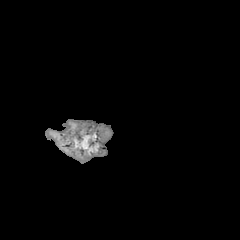

In [55]:
Image.open(list(image_embeddings.keys())[0])

In [57]:
list(image_embeddings.values())[0]

array([0.35618728, 0.34230423, 0.09550171, ..., 0.03066884, 0.72184193,
       0.16519433], dtype=float32)

In [56]:

import pickle
with open('/mnt/gs/picture_embeddings/imagenet_resnets/raw_cutouts_imagenet_152_embeddings.pickle', 'wb') as handle:
  pickle.dump(image_embeddings, handle, protocol = pickle.HIGHEST_PROTOCOL )